# 1. Obtendo e revisando os dados

Recentemente fui fazer atividade física com um amigo e ele estava usando um Smartwatch.

Ao finalizarmos a corrida, ele comentou a quantidade de quilômetros que fizemos, o tempo e as calorias queimadas.

E que ele armazena esses dados em um aplicativo chamado mifit.

Ultimamente tenho conversado bastante com ele sobre atividade física, alimentação e tudo que envolve o meio fitness e percebi que eu poderia fazer uma análise mais profunda dos meus treinos utilizando esses dados.

![](images/OLD8ZD0.jpg)

Enquanto meu Smartwatch não chega ...

Eu procurei algum dataset que tivesse dados parecidos com os que o aplicativo mifit fornece para começar a praticar as análises.

E acabei achando um conjunto de dados bem legal e vou apresentar alguns resultados do que eu consegui extrair dele.

In [238]:
# Import pandas
import pandas as pd

# Define file containing dataset
runkeeper_file = 'datasets/cardioActivities.csv'

# Create DataFrame with parse_dates and index_col parameters 
df_activities = pd.read_csv(runkeeper_file, parse_dates=['Date'], index_col="Date")

# First look at exported data: select sample of 3 random rows 
display(df_activities.sample(3))

# Print DataFrame summary
print(df_activities.info())

,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2015-05-29 18:45:22,748d5149-2314-4bd0-8528-59d7e7ffee1d,Running,NaN,9.73,46:22,4:46,12.59,636.0,84,150.0,NaN,NaN,2015-05-29-184522.gpx
2018-08-28 18:44:33,c9a8e088-441d-4b3f-bfbc-287e87585ca7,Cycling,NaN,28.17,1:27:07,3:06,19.40,685.0,400,111.0,NaN,NaN,2018-08-28-184433.gpx
2017-12-04 18:14:41,45475dee-1fba-4bc5-bdf1-1ca458d0b20a,Running,NaN,10.00,59:43,5:58,10.05,717.0,160,142.0,NaN,TomTom MySports Watch,2017-12-04-181441.gpx


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2018-11-11 14:05:12 to 2012-08-22 18:53:54
Data columns (total 13 columns):
Activity Id                 508 non-null object
Type                        508 non-null object
Route Name                  1 non-null object
Distance (km)               508 non-null float64
Duration                    508 non-null object
Average Pace                508 non-null object
Average Speed (km/h)        508 non-null float64
Calories Burned             508 non-null float64
Climb (m)                   508 non-null int64
Average Heart Rate (bpm)    294 non-null float64
Friend's Tagged             0 non-null float64
Notes                       231 non-null object
GPX File                    504 non-null object
dtypes: float64(5), int64(1), object(7)
memory usage: 55.6+ KB
None


Veja que temos um dataset com 508 linhas e 13 colunas, com dados de 22 de agosto de 2012 até 11 de novembro de 2018. 

# 2. Processamento dos dados

Para nossa sorte, os nomes de coluna que o Runkeeper fornece são informativos e não precisamos renomear nenhuma coluna.

Porém, observamos algumas colunas com dados ausentes usando o método info(). 

Quais são as razões para esses valores ausentes? Depende. 

Faltam algumas informações sobre a frequência cardíaca, porque nem sempre o corredor usou um sensor cardiovascular. 

No caso da coluna Notes, é um campo opcional que às vezes ele deixou em branco. 

Além disso, ele usou a coluna Route name apenas uma vez e nunca usou a coluna Friend's Tagged.

Vamos preencher os valores ausentes na coluna da frequência cardíaca para evitar resultados enganosos mais tarde, mas agora, nossas primeiras etapas de pré-processamento de dados serão:

- Remover as colunas que não são úteis para nossa análise.
- Substituir o tipo de atividade "Other" por "Unicycling", porque essa sempre foi a atividade "Other".
- Calcular os dados ausentes. 

In [239]:
# Define list of columns to be deleted
cols_to_drop = [ "Friend's Tagged", 'Route Name','GPX File', 'Activity Id','Notes']

# Delete unnecessary columns
df_activities = df_activities.drop(columns = cols_to_drop)

# Rename 'Other' type to 'Unicycling'
df_activities['Type'] = df_activities['Type'].str.replace('Other', 'Unicycling' )

# Count types of training activities
display(df_activities['Type'].value_counts())

# Count missing values for each column
df_activities.isnull().sum()

Running       459
Cycling        29
Walking        18
Unicycling      2
Name: Type, dtype: int64

Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Calories Burned               0
Climb (m)                     0
Average Heart Rate (bpm)    214
dtype: int64

Observe que a maioria das atividades registradas foram de corrida.

# 3. Lidando com os dados ausentes

Como podemos ver na última saída, existem 214 dados ausentes da frequência cardíaca média.

Não podemos voltar no tempo para obter esses dados, mas podemos preencher os valores ausentes com um valor médio. 

Esse processo é chamado de imputação média. 

Ao imputar a média para preencher dados ausentes, precisamos considerar que a frequência cardíaca média varia para diferentes atividades (por exemplo, `caminhada x corrida`). 

Vamos filtrar os DataFrames por tipo de atividade (Type) e em seguida calcular a freqüência cardíaca média de cada atividade, e preencheremos os valores ausentes com essas médias.

In [240]:
# Calculate sample means for heart rate for each training activity type 
avg_hr_run = df_activities[df_activities['Type'] == 'Running']['Average Heart Rate (bpm)'].mean()
avg_hr_cycle = df_activities[df_activities['Type'] == 'Cycling']['Average Heart Rate (bpm)'].mean()

# Split whole DataFrame into several, specific for different activities
df_run = df_activities[df_activities['Type'] == 'Running'].copy()
df_walk = df_activities[df_activities['Type'] == 'Walking'].copy()
df_cycle = df_activities[df_activities['Type'] == 'Cycling'].copy()

# Filling missing values with counted means  
df_walk['Average Heart Rate (bpm)'].fillna(110, inplace=True)
df_run['Average Heart Rate (bpm)'].fillna(int(avg_hr_run), inplace=True)
df_cycle['Average Heart Rate (bpm)'].fillna(int(avg_hr_cycle), inplace=True)

# Count missing values for each column in running data
df_run.isnull().sum()

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Calories Burned             0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

Perceba que o batimento cardíaco médio foi preenchido com o valor de 110 ao invés da sua média.

Isso ocorreu pois não foram coletados dados de batimento cardíaco quando o tipo de exercício era caminhada. Como você pode observar abaixo

In [241]:
# Visualize Average Heart Rate (bpm) 
df_activities[df_activities['Type'] == 'Walking'].head(18)

,Type,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm)
Date,,,,,,,,
2013-08-15 18:49:50,Walking,2.48,2:23:46,57:56,1.04,306.0,67,NaN
2013-08-08 07:56:08,Walking,1.51,15:24,10:11,5.89,85.0,6,NaN
2013-06-03 07:04:59,Walking,1.33,11:59,9:03,6.63,76.0,5,NaN
2013-04-29 18:48:30,Walking,1.37,22:39,16:30,3.64,95.0,10,NaN
2013-04-29 13:10:14,Walking,3.83,38:30,10:04,5.96,255.0,25,NaN
2013-04-28 10:56:47,Walking,1.32,13:48,10:30,5.72,67.0,5,NaN
2013-04-18 21:48:44,Walking,1.50,24:41,16:28,3.64,86.0,9,NaN
2013-03-11 18:27:56,Walking,1.86,16:39,8:56,6.72,116.0,16,NaN
2012-11-04 18:59:06,Walking,1.22,12:05,9:54,6.07,67.0,10,NaN


Agora temos os dados limpos e prontos para serem analisados.

# 4. Plotando dados de corrida

Agora podemos criar nosso primeiro gráfico! 

Como descobrimos anteriormente, a maioria das atividades nos dados foram de running (459 para ser exato). 

Existem apenas 29, 18 e duas instâncias para cycling, walking, e unicycling, respectivamente. 

Então, por enquanto, vamos nos concentrar na plotagem das diferentes métricas de corrida.

Uma excelente primeira visualização é uma figura com quatro subplots, uma para cada métrica de corrida (cada coluna numérica). 

Cada subplot terá um eixo y diferente, explicado em cada legenda. 

O eixo x, Data, é o mesmo em todos subplots.

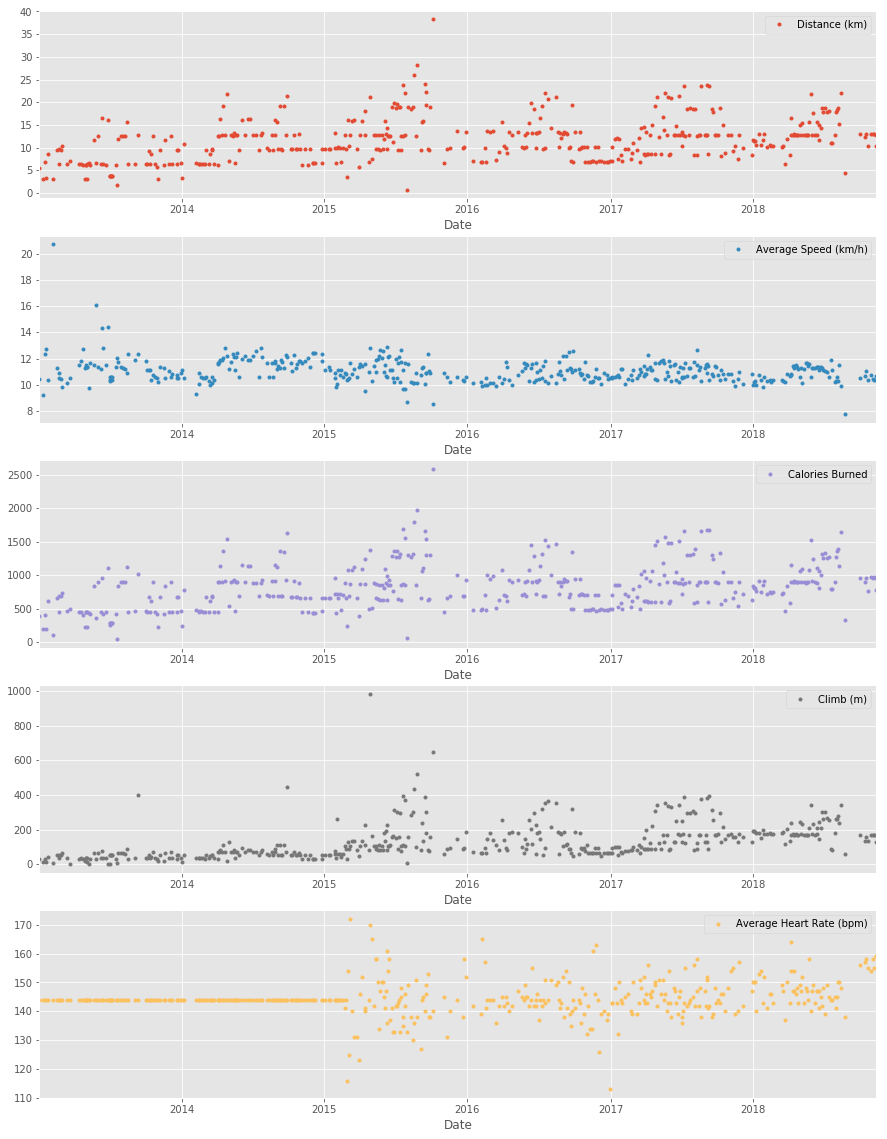

In [242]:
# Import matplotlib, set style and ignore warning
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
plt.style.use('ggplot')
warnings.filterwarnings(
    action='ignore', module='matplotlib.figure', category=UserWarning,
    message=('This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.')
)

# Prepare data subsetting period from 2013 till 2018
runs_subset_2013_2018 = df_run.loc['2018':'2013']

# Create, plot and customize in one step
runs_subset_2013_2018.plot(subplots=True,
                           sharex=False,
                           figsize=(15,20),
                           linestyle='none',
                           marker='o',
                           markersize=3,
                          )

# Show plot
plt.show()

Observe que a distância percorrida e quantidade de calorias queimadas estão bem correlacionadas, como esperado, já que quanto maior a distância percorrida, maior será a quantidade de energia gasta.

Uma pergunta relevante e bastante discutida é: Queimamos mais calorias correndo por mais tempo em baixa intensidade ou correndo menos tempo em alta intensidade?

Há pesquisas mostrando que treinos de curta duração de alta intensidade com intervalos são mais eficientes na queima de calorias.

Logo mais tentaremos responder essa pergunta.

# 5. Estatísticas das corridas

Mas antes, vamos responder algumas perguntas que são mais frequentes entre pessoas que praticam esse esporte. Por exemplo:

- Qual a distância média que você percorre?
- Quão rápido você corre?
- Com que frequência você treina?
- Você mede sua frequência cardíaca?

Vamos encontrar respostas para essas perguntas nesses dados.

E se você já olhar o gráfico de batimento cardíaco médio, você consegue perceber que essa pessoa só começou a medir sua frequência cardíaca de 2015 em diante.

No pandas, o método resample é parecido com o groupby. Ele permite que que você agrupe os dados por um período de tempo específico.

Vamos visualizar informações dos dados anualmente e semanalmente.

In [243]:
 # Prepare running data for the last 4 years
runs_subset_2015_2018 = df_run['2018':'2015']

# Calculate annual statistics
print('Como foram suas corridas nos últimos 4 anos:')
display(runs_subset_2015_2018.resample('A').mean().mean())

# Calculate weekly statistics
print('Médias semanais dos últimos 4 anos:')
display(runs_subset_2015_2018.resample('W').mean().mean())

# Mean weekly counts
weekly_counts_average = runs_subset_2015_2018['Distance (km)'].resample('W').count().mean()
print('Quantos treinos por semana, em média, essa pessoa fez:', weekly_counts_average)

Como foram suas corridas nos últimos 4 anos:


Distance (km)                12.822178
Average Speed (km/h)         10.893427
Calories Burned             898.895749
Climb (m)                   163.490099
Average Heart Rate (bpm)    145.028652
dtype: float64

Médias semanais dos últimos 4 anos:


Distance (km)                12.518176
Average Speed (km/h)         10.835473
Calories Burned             877.861969
Climb (m)                   158.325444
Average Heart Rate (bpm)    144.801775
dtype: float64

Quantos treinos por semana, em média, essa pessoa fez: 1.5


Observe que nos últimos 4 anos, essa pessoa percorreu, em média, 12 km por corrida, correndo á uma velocidade média de aproximadamente 11 km/h e queimando aproximadamente 900 calorias, treinando "uma vez e meia" por semana, ou seja, a cada 1 mês, ele faz, em média, 6 treinos.

# 6. Comparando as performances dos treinos com suas médias

Vamos traçar as médias de longo prazo da distância percorrida, da velocidade média e das calorias queimadas com os dados brutos para comparar visualmente as médias de cada sessão de treinamento. 

Novamente, usaremos os dados de 2015 a 2018.

Nesta tarefa, usaremos a funcionalidade matplotlib para criação e customização dos gráficos.

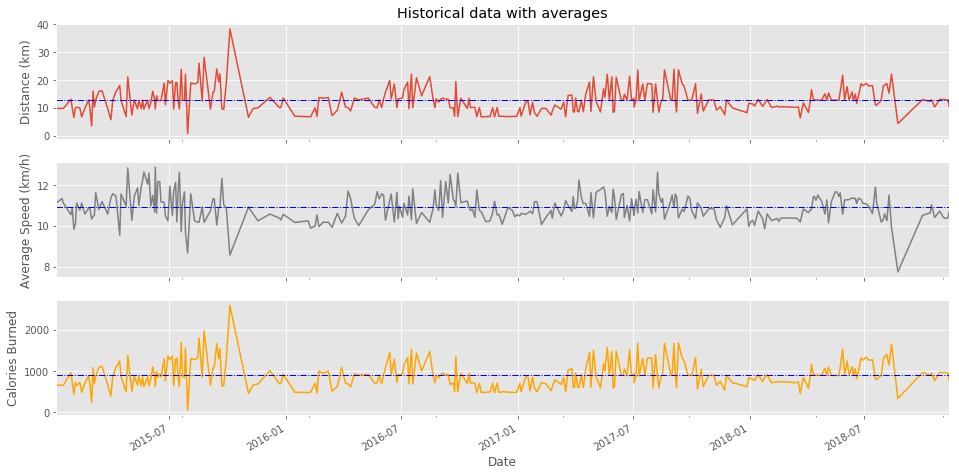

In [244]:
# Prepare data
runs_subset_2015_2018 = df_run['2018':'2015']
runs_distance = runs_subset_2015_2018['Distance (km)']
runs_avg_speed = runs_subset_2015_2018['Average Speed (km/h)']
runs_cal = runs_subset_2015_2018['Calories Burned']

# Create plot
fig, (ax1, ax2, ax3) =plt.subplots(3, 1, sharex=True, figsize=(16,8))

# Plot and customize first subplot
runs_distance.plot(ax=ax1)
ax1.set(ylabel='Distance (km)', title='Historical data with averages')
ax1.axhline(runs_distance.mean(), color='blue', linewidth=1, linestyle='-.')

# Plot and customize second subplot
runs_avg_speed.plot(ax=ax2, color='gray')
ax2.set(ylabel='Average Speed (km/h)')
ax2.axhline(runs_avg_speed.mean(), color='blue', linewidth=1, linestyle='-.')

# Plot and customize third subplot
runs_cal.plot(ax=ax3, color='orange')
ax3.set(xlabel='Date', ylabel='Calories Burned')
ax3.axhline(runs_cal.mean(), color='blue', linewidth=1, linestyle='-.')

# Show plot
plt.show()

Observe que um padrão acontece no início e na metade de cada ano.

Nos inícios do anos, grande parte das corridas feitas por ele foram abaixo da média.

Já nas metades dos anos, ele conseguiu fazer corridas bem melhores.

# 7. O atleta alcançou seus objetivos?

Digamos que para se motivar a correr regularmente, o atleta estabeleceu uma meta de correr 1000 km por ano.

Vamos visualizar a distância de corrida anual de 2013 à 2018 para ver em quais anos ele alcançou a meta.

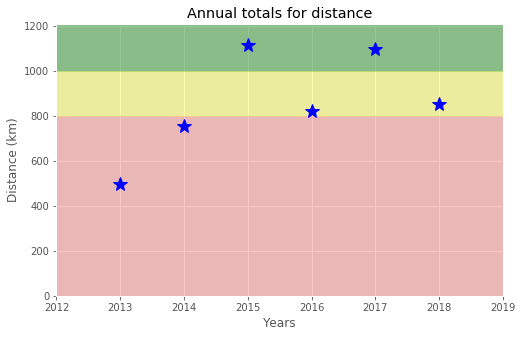

In [245]:
# Prepare data
df_run_dist_annual = df_run['2018':'2013']['Distance (km)'].resample('A').sum()

# Create plot
fig = plt.figure(figsize=(8,5))

# Plot and customize
ax = df_run_dist_annual.plot(marker='*', markersize=14, linewidth=0, color='blue')
ax.set(ylim=[0, 1210], 
       xlim=['2012','2019'],
       ylabel='Distance (km)',
       xlabel='Years',
       title='Annual totals for distance')

ax.axhspan(1000, 1210, color='green', alpha=0.4)
ax.axhspan(800, 1000, color='yellow', alpha=0.3)
ax.axhspan(1,800, color='red', alpha=0.2)

# Show plot
plt.show()

Somente as estrelas que estão na região verde indicam o alcanço da meta.

Veja que nos anos de 2015 e 2017 o atleta alcançou seu objetivo.

Sendo o ano de 2013 o período de pior performance.


# 8. O atleta está progredindo ao longo do tempo?

Vamos tentar responder uma pergunta um pouco mais complicada: `O atleta está progredindo nas suas corridas?`

Para responder essa pergunta, vamos decompor a distância semanal percorrida e comparar visualmente com os dados brutos.

Vamos representar a distância semanal com uma linha de tendência.

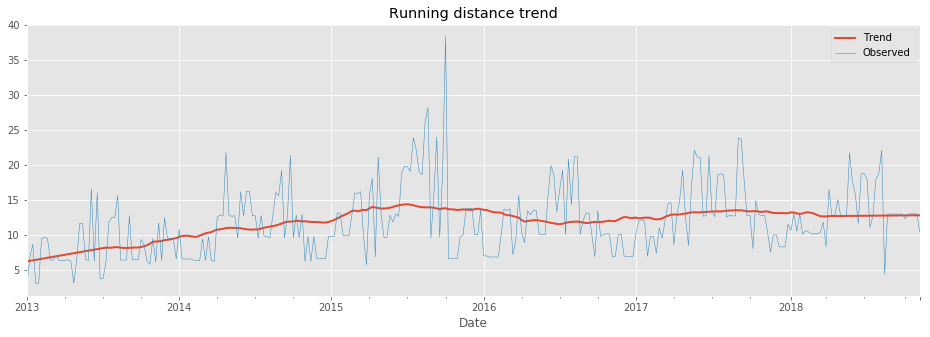

In [246]:
# Import required library
import statsmodels.api as sm

# Prepare data
df_run_dist_wkly = df_run['2018':'2013']['Distance (km)'].resample('W').fillna(method = 'bfill')
decomposed = sm.tsa.seasonal_decompose(df_run_dist_wkly, extrapolate_trend=1, freq=52)

# Create plot
fig = plt.figure(figsize=(16,5))

# Plot and customize
ax = decomposed.trend.plot(label='Trend', linewidth=2)
ax = decomposed.observed.plot(label='Observed', linewidth=0.5)

ax.legend()
ax.set_title('Running distance trend')

# Show plot
plt.show()

Veja que a distância semanal teve um aumento considerável, saindo de pouco mais de 5 km para aproximadamente 13 km.

Observe também que por volta da metade do ano de 2015 o atleta percorreu distâncias maiores, comparando com todas outras, seria interessante entender o que aconteceu nesse período e entender o que levou ele a performar tão acima da média.

# 9. Intensidade dos treinos

A frequência cardíaca é uma métrica popular usada para medir a intensidade do treinamento. 

Dependendo da idade e do nível de condicionamento físico, as frequências cardíacas são agrupadas em diferentes zonas que as pessoas podem atingir, dependendo das metas de treinamento. 

Uma frequência cardíaca alvo durante atividades de intensidade moderada é de cerca de 50-70% da freqüência cardíaca máxima, enquanto durante atividade física vigorosa é de 70-85% da máxima.

Vamos criar um gráfico de distribuição dos dados de frequência cardíaca por intensidade de treinamento. 

Será uma apresentação visual para o número de atividades de zonas de treinamento pré-definidas.

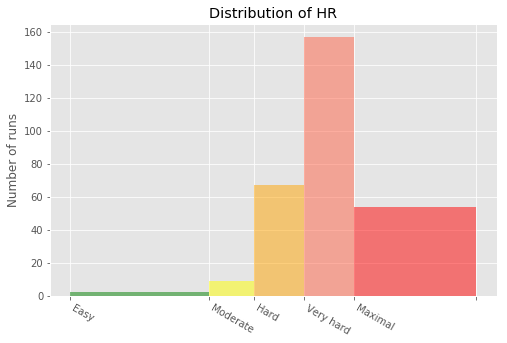

In [247]:
# Prepare data
hr_zones = [100, 125, 133, 142, 151, 173]
zone_names = ['Easy', 'Moderate', 'Hard', 'Very hard', 'Maximal']
zone_colors = ['green', 'yellow', 'orange', 'tomato', 'red']
df_run_hr_all = df_run['2018':'2015-03']['Average Heart Rate (bpm)']

# Create plot
fig, ax = plt.subplots(figsize=(8,5))

# Plot and customize
n, bins, patches = ax.hist(df_run_hr_all, bins=hr_zones, alpha=0.5)
for i in range(0, len(patches)):
    patches[i].set_facecolor(zone_colors[i])

ax.set(title='Distribution of HR', ylabel='Number of runs')
ax.xaxis.set(ticks=hr_zones)
ax.set_xticklabels(labels=zone_names, rotation=-30, ha='left')

# Show plot
plt.show()

Veja que a maioria das corridas foram de alta intensidade.

Essas informações serão bastante importantes para respondermos a pergunta que levantamos no começo do artigo:

Quando o atleta queimou mais calorias? 

Quando treinou menos tempo com um intensidade mais alta?

Ou quando treinou mais tempo com uma intensidade mais baixa?

# 10. Qual tipo de treino queimou mais calorias?

Agora vamos, de fato, tentar responder a pergunta que, para mim, é a mais interessante:

**`O atleta queimou mais calorias correndo por mais tempo em baixa intensidade ou correndo menos tempo em alta intensidade?`**

Para respondermos essa pergunta, primeiro precisamos preparar os dados de duração de treino. Vamos transformar-los para segundos.

Em seguida iremos filtrar as corridas que foram com alta intensidade e de baixa duração (considerei os treinos de 'Hard' à 'Maximal' e com duração de até 30 minutos).

E os treinos de baixa intensidade e com longa duração, considerei sendo os treinos com intensidade leve e moderada com duração de mais de 1 hora.

Por fim, vamos tentar responder qual treino queimou mais calorias.

Average Calories Burned (Hiit): 67554.73529411765
Average Calories Burned (Cardio): 1182.744185782717


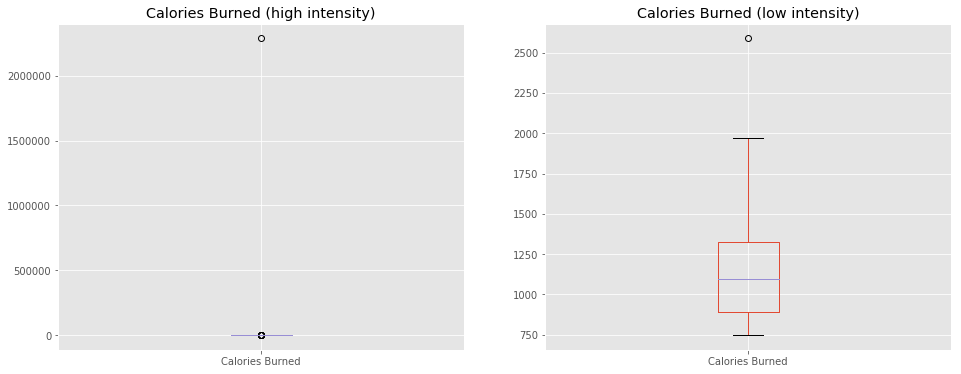

In [248]:
# Transform the running duration to seconds
df_run['Duration_seg'] = df_run['Duration'].apply(lambda x: pd.to_datetime(pd.Series(x),format='%M:%S') 
                                                  if len(x)<6 else pd.to_datetime(pd.Series(x), format='%H:%M:%S'))

df_run['Duration_seg'] = df_run['Duration_seg'].apply(lambda x: pd.to_timedelta(str(x.time()), unit='s').total_seconds())

# filter the data
df_run_hiit = df_run[(df_run['Average Heart Rate (bpm)']>142) & (df_run['Duration_seg']<1800)]
df_run_cardio = df_run[(df_run['Average Heart Rate (bpm)']<142) & (df_run['Duration_seg']>3600)]

# Calculating the average calorie burned for each type of run
print('Average Calories Burned (Hiit):', df_run_hiit['Calories Burned'].mean())
print('Average Calories Burned (Cardio):', df_run_cardio['Calories Burned'].mean())

# Create plot
fig, (ax1, ax2) =plt.subplots(1, 2, sharex=True, figsize=(16,6))

# Plot and customize first subplot
df_run_hiit['Calories Burned'].plot(ax=ax1, kind='box')
ax1.set(title='Calories Burned (high intensity)')

# Plot and customize second subplot
df_run_cardio['Calories Burned'].plot(ax=ax2, kind='box')
ax2.set( title='Calories Burned (low intensity)')

# Show plot 
plt.show()

Perceba que se olharmos apenas para a caloria média queimada para cada tipo de treino, teríamos uma percepção totalmente errada do que nossos dados realmente estão querendo dizer.

Pois como você pode ver no boxplot do treino de alta intensidade, existe um outlier que compromete totalmente o valor da métrica, pois ela é muito sensível a outliers, o que fez com que as calorias queimadas nos treinos de alta intensidade aparenta ser muito maior do que realmente é.

Para esse caso, comparar as medianas ou comparar novamente os boxplots, removendo o outlier, nos fornecerá uma informação mais assertiva de qual treino está queimando mais calorias para esse atleta.

Median of Calories Burned (Hiit): 229.0
Median of Calories Burned (Cardio): 1097.0


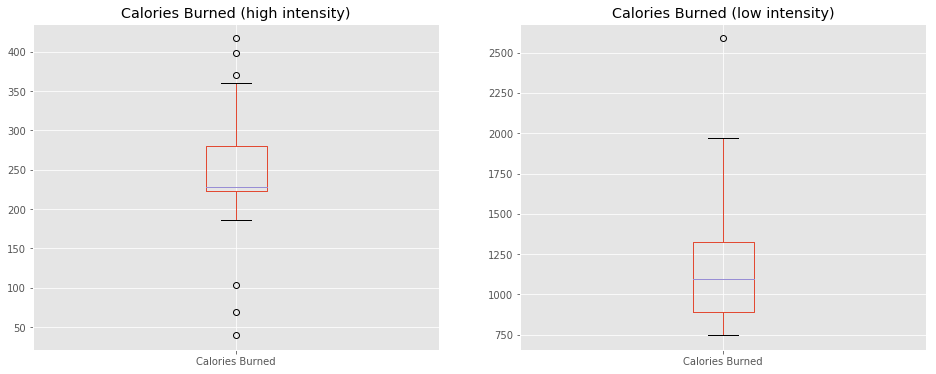

In [252]:
# Calculating the average calorie burned for each type of run
print('Median of Calories Burned (Hiit):', df_run_hiit['Calories Burned'].median())
print('Median of Calories Burned (Cardio):', df_run_cardio['Calories Burned'].median())

# Create plot
fig, (ax1, ax2) =plt.subplots(1, 2, sharex=True, figsize=(16,6))

# Plot and customize first subplot
df_run_hiit[df_run_hiit['Calories Burned']<500]['Calories Burned'].plot(ax=ax1, kind='box')
ax1.set( title='Calories Burned (high intensity)')

# Plot and customize second subplot
df_run_cardio['Calories Burned'].plot(ax=ax2, kind='box')
ax2.set( title='Calories Burned (low intensity)')

# Show plot 
plt.show()

Agora fica bem mais fácil afirmar que, com base nos treinos analisados desse atleta, ele tende a queimar mais calorias quando faz corridas mais longas com menor intensidade.

Veja que o treino de baixa intensidade que queimou menos calorias, ainda queimou uma quantidade maior de calorias que o treino de alta intensidade que queimou mais calorias.

Espero em breve trazer as análises dos meus próprios dados de treinamento e tirar vários insights para que eu possa melhorar minha performance e saúde.

## Comentários ou Dúvidas?

- Email: <contato@viniciusgalvaoia.com.br>
- Site: http://viniciusgalvaoia.com.br

#### Vinícius Galvão | Data Scientist